In [1]:
import pandas as pd
df = pd.read_csv('sales.csv', usecols=["order_id", "order_date"])


/tmp/ipykernel_10435/870162157.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sales.csv', usecols=["order_id", "order_date"])


In [2]:
df.drop_duplicates(subset=["order_id"], inplace=True, ignore_index=True)

In [3]:
df.head()

,order_id,order_date
0,100354678,2020-10-01
1,100354680,2020-10-01
2,100367357,2020-11-13
3,100367360,2020-11-13
4,100354677,2020-10-01


In [4]:
# Convert 'order_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract the week number from 'order_date'
df['week'] = df['order_date'].dt.isocalendar().week

# Group by week and count 'order_id'
result = df.groupby('week')['order_id'].count().reset_index()

# Rename the column
result.columns = ['week', 'number_of_order']
df = result.iloc[1:-1]
# df = result

In [5]:
df.head()

,week,number_of_order
1,2,2701
2,3,1891
3,4,1492
4,5,2538
5,6,1489


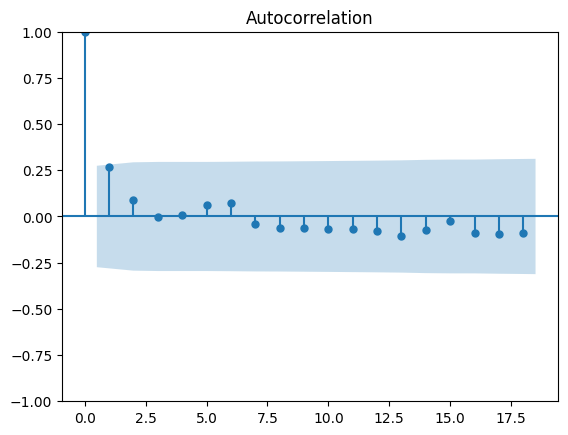

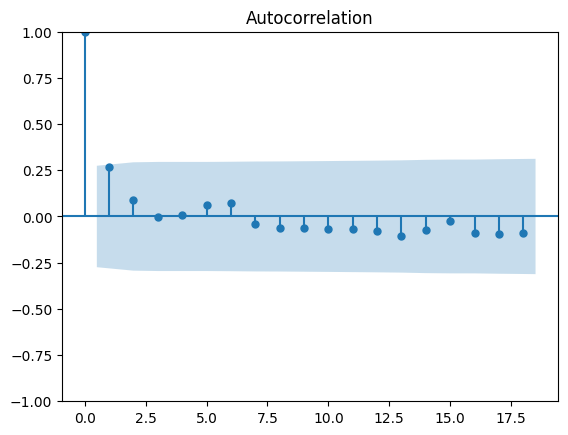

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function for the 'value' column of the dataframe
plot_acf(df.number_of_order)


2    -810.0
3    -399.0
4    1046.0
5   -1049.0
6    -236.0
Name: number_of_order, dtype: float64
Length before dropna: 51, after dropna: 50


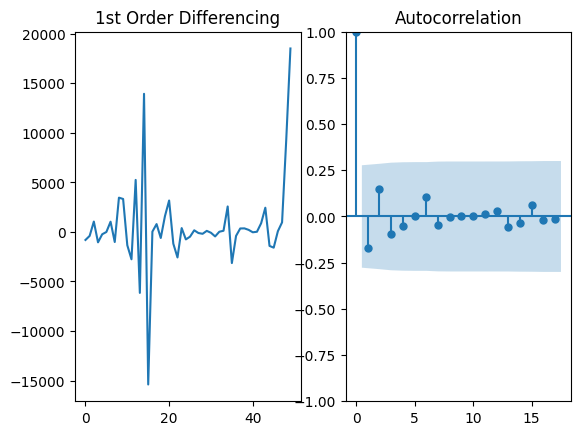

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Check if the 'value' column is numeric and inspect the diffed series
diff_series = df['number_of_order'].diff().dropna()

# Inspect before plotting
print(diff_series.head())
print(f"Length before dropna: {len(df['number_of_order'].diff())}, after dropna: {len(diff_series)}")

# If the diffed series is fine, proceed with plotting
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')

# Plot the differenced series, using .values for numpy array
ax1.plot(diff_series.values)

# Second subplot: Plot the ACF of the differenced series
ax2 = f.add_subplot(122)
plot_acf(diff_series, ax=ax2)

plt.show()


3     411.0
4    1445.0
5   -2095.0
6     813.0
7     230.0
Name: number_of_order, dtype: float64
Length before dropna: 51, after dropna: 49


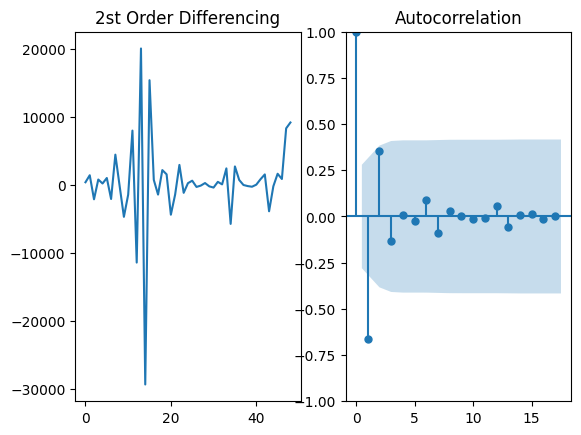

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Check if the 'value' column is numeric and inspect the diffed series
diff_series = df['number_of_order'].diff().diff().dropna()

# Inspect before plotting
print(diff_series.head())
print(f"Length before dropna: {len(df['number_of_order'].diff().diff())}, after dropna: {len(diff_series)}")

# If the diffed series is fine, proceed with plotting
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('2st Order Differencing')

# Plot the differenced series, using .values for numpy array
ax1.plot(diff_series.values)

# Second subplot: Plot the ACF of the differenced series
ax2 = f.add_subplot(122)
plot_acf(diff_series, ax=ax2)

plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.number_of_order.dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().diff().diff().dropna())
print('p-value: ', result[1])


p-value:  0.5948750301688045
p-value:  2.3191343489960987e-10
p-value:  2.4069914366563067e-10
p-value:  4.998137507326206e-05


In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (order = (1, 1, 2))
arima_model = ARIMA(df.number_of_order, order=(3, 1, 2))
model = arima_model.fit()

# Print the summary
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:        number_of_order   No. Observations:                   51
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -488.876
Date:                Sun, 15 Dec 2024   AIC                            989.752
Time:                        15:08:21   BIC                           1001.224
Sample:                             0   HQIC                           994.121
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2525      0.262      0.965      0.335      -0.261       0.766
ar.L2         -0.6841      0.263     -2.598      0.009      -1.200      -0.168
ar.L3         -0.3436      0.258     -1.330      0.1

/home/andv/VCS/visualization/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/andv/VCS/visualization/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


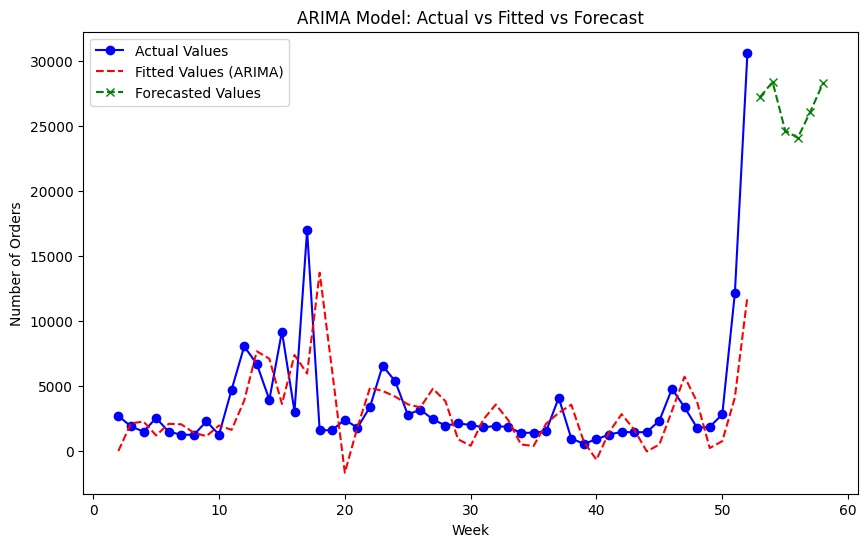

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions (fitted values)
fitted_values = model.fittedvalues

# Plot the actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(df['week'], df['number_of_order'], label='Actual Values', color='blue', marker='o')
plt.plot(df['week'], fitted_values, label='Fitted Values (ARIMA)', color='red', linestyle='--')

# Optionally forecast future values (e.g., next 2 weeks)
forecast_steps = 6
forecast = model.forecast(steps=forecast_steps)
forecast_index = np.arange(df['week'].max() + 1, df['week'].max() + 1 + forecast_steps)

# Plot forecasted values
plt.plot(forecast_index, forecast, label='Forecasted Values', color='green', marker='x', linestyle='--')

# Add labels and legend
plt.title('ARIMA Model: Actual vs Fitted vs Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()

# Show plot
plt.show()


In [18]:
import plotly.graph_objects as go
import numpy as np

# Prepare the data
weeks = df['week']
actual_values = df['number_of_order']
fitted_values = model.fittedvalues

# Forecast the future values
forecast_steps = 6
forecast = model.forecast(steps=forecast_steps)
forecast_index = np.arange(df['week'].max() + 1, df['week'].max() + 1 + forecast_steps)

# Create a plotly figure
fig = go.Figure()

# Add actual values as a scatter plot
fig.add_trace(go.Scatter(
    x=weeks,
    y=actual_values,
    mode='markers+lines',
    name='Actual Values',
    line=dict(color='blue'),
    marker=dict(symbol='circle', size=8),
    text=[f'Week {w}: {v}' for w, v in zip(weeks, actual_values)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Add fitted values (ARIMA model)
fig.add_trace(go.Scatter(
    x=weeks,
    y=fitted_values,
    mode='lines',
    name='Fitted Values (ARIMA)',
    line=dict(color='red', dash='dash'),
    text=[f'Week {w}: {v}' for w, v in zip(weeks, fitted_values)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Add forecasted values
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast,
    mode='markers+lines',
    name='Forecasted Values',
    line=dict(color='green'),
    marker=dict(symbol='x', size=10),
    text=[f'Week {w}: {v}' for w, v in zip(forecast_index, forecast)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Update layout
fig.update_layout(
    title='ARIMA Model: Actual vs Fitted vs Forecast',
    xaxis_title='Week',
    yaxis_title='Number of Orders',
    legend_title='Legend',
    hovermode='closest'  # Ensure hover shows info for closest point
)

# Show the plot
fig.show()
